In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import pickle
import numpy as np

In [3]:
directory = r'D:\Thesis Paper\VGG16\Dataset\lung_image_sets'

In [4]:
Categories  = ['lung_adenocarcinomas','lung_normal','lung_squamous_cell_carcinomas']

In [5]:
training_data = []

In [ ]:
def make_data(directory):
    for category in Categories:
        path = os.path.join(directory,category) # link the path with the desire directory
        label = Categories.index(category)
        print(path)
        print(label)

        for img_name in os.listdir(path): # read every image in the folder, path defines the folder 
            img_path = os.path.join(path,img_name)
            img = cv2.imread(img_path) # read the image
            img = cv2.resize(img,(150,150)) # resize to 150px
            img = np.array(img, dtype = np.float32) # convert image to array
        
            training_data.append([img,label])

    print(len(training_data))
    


In [17]:
make_data(directory)

D:\Thesis Paper\VGG16\Dataset\lung_image_sets\lung_adenocarcinomas
0
D:\Thesis Paper\VGG16\Dataset\lung_image_sets\lung_normal
1
D:\Thesis Paper\VGG16\Dataset\lung_image_sets\lung_squamous_cell_carcinomas
2
15000


In [18]:
pik = open('training_dataset.pickle','wb')
pickle.dump(training_data,pik)
pik.close()

In [19]:
training_data

[[array([[[241., 196., 212.],
          [242., 198., 211.],
          [244., 201., 210.],
          ...,
          [225.,  92., 155.],
          [220.,  84., 150.],
          [226.,  87., 155.]],
  
         [[242., 197., 213.],
          [244., 200., 213.],
          [245., 202., 211.],
          ...,
          [228.,  97., 162.],
          [220.,  84., 152.],
          [223.,  83., 154.]],
  
         [[242., 197., 213.],
          [244., 200., 213.],
          [245., 202., 211.],
          ...,
          [243., 129., 178.],
          [232., 114., 168.],
          [229., 108., 165.]],
  
         ...,
  
         [[213., 115., 184.],
          [215., 110., 182.],
          [225., 121., 181.],
          ...,
          [224., 134., 163.],
          [221., 134., 164.],
          [234., 149., 181.]],
  
         [[220., 111., 188.],
          [210., 100., 180.],
          [217., 110., 182.],
          ...,
          [228., 131., 161.],
          [213., 118., 149.],
          [222., 127.,

In [20]:
len(training_data)

15000

In [21]:
X = []
y = []

In [ ]:
def load_data(dataSetName):
    pick = open(dataSetName,'rb') # open the pickle file
    data = pickle.load(pick) # load the pickle file and store to data
    pick.close()

    np.random.shuffle(data) # shuffle all the images

    features = []
    labels = []

    for img,label in data:
        features.append(img)
        labels.append(label)

    features = np.array(features,dtype = np.float32)
    labels = np.array(labels,dtype = np.float32)

    features = features / 255.0

    return [features,labels]


In [22]:
# np.random.shuffle(training_data)
# for features , labels  in training_data:
#     features = np.array(features,dtype = np.float32)
#     labels = np.array(labels,dtype = np.float32)
#     features = features / 255.0
#     X.append(features)
#     y.append(labels)

In [8]:
# load_data()
x,y = load_data('training_dataset.pickle')

In [10]:
len(x)

15000

In [28]:
# X = np.array(X)

In [11]:
y = y.reshape(-1,)

In [12]:
x.shape

(15000, 150, 150, 3)

In [13]:
y[:8].astype(int)

array([0, 2, 2, 2, 1, 1, 2, 0])

In [14]:
#Split into train test dataset

from sklearn.model_selection import train_test_split

x_train , x_test , y_train ,y_test  = train_test_split(x,y,test_size = 0.2,random_state = 42)

In [15]:
x_train.shape

(12000, 150, 150, 3)

In [16]:
x_test.shape

(3000, 150, 150, 3)

In [17]:
x_test.shape[3]

3

In [18]:
def plot_sample(x,y,index):
    plt.figure(figsize = (15,2))
    plt.imshow(x[index])
    plt.xlabel(Categories[int(y[index])]) # for labeling by name
    plt.xlabel(Categories[int(y[index])])

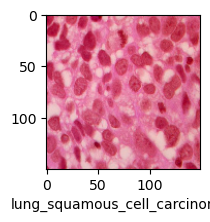

In [19]:
plot_sample(x_train,y_train,65)

In [20]:
#Build VGG16 Model
import tensorflow as tf
from tensorflow import keras
from keras.applications import vgg16


In [ ]:
vgg = vgg16.VGG16(weights = 'imagenet' , input_shape = (150,150,3),include_top = False) #Cut off the fully connected layer
#VGG-16 normally has 3 dense layers at the end

In [22]:
#Freezing other 13 conv layers
for layer in vgg.layers:
    layer.trainable = False
    

In [23]:
#including Top layer

vgg16Model = keras.Sequential([
    vgg,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(3, activation = 'softmax'),
    
])

In [24]:
vgg16Model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
import time
import tensorflow as tf

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.step_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.step_times_per_epoch = []  # reset step times for each epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)

    def on_train_batch_begin(self, batch, logs=None):
        self.batch_start_time = time.time()

    def on_train_batch_end(self, batch, logs=None):
        step_time = time.time() - self.batch_start_time
        self.step_times_per_epoch.append(step_time)

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_time)
        self.step_times.append(self.step_times_per_epoch)  # store step times for this epoch


In [26]:
time_callback = TimeHistory()

In [27]:
history = vgg16Model.fit(x_train, y_train, 
                         validation_data=(x_test, y_test),  # Add validation data here
                         batch_size=100, 
                         epochs=40, 
                         callbacks=[time_callback])


Epoch 1/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.8283 - loss: 0.3575 - val_accuracy: 0.9493 - val_loss: 0.1344
Epoch 2/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 272s 2s/step - accuracy: 0.9549 - loss: 0.1131 - val_accuracy: 0.9563 - val_loss: 0.1214
Epoch 3/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.9597 - loss: 0.1021 - val_accuracy: 0.9680 - val_loss: 0.0881
Epoch 4/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9663 - loss: 0.0858 - val_accuracy: 0.9697 - val_loss: 0.0798
Epoch 5/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9693 - loss: 0.0756 - val_accuracy: 0.9723 - val_loss: 0.0712
Epoch 6/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.9738 - loss: 0.0664 - val_accuracy: 0.9760 - val_loss: 0.0670
Epoch 7/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9811 - loss: 0.0511 - val_accuracy: 0.9830 - val_loss: 0.0488
Epoch 8/40
120/120 ━━━━━━━━━━━━━━━━━━━━ 271s 2s/step - accuracy: 0.9814 - loss: 0.0475 - val_accu

In [28]:
with open("VGG16Model.pkl", "wb") as file:  # "wb" means write binary
    pickle.dump(vgg16Model, file)

In [29]:
with open("VGG16Model.h5", "wb") as file:  # "wb" means write binary
    pickle.dump(vgg16Model, file)

In [30]:
with open("Training History.pkl", "wb") as file:  # "wb" means write binary
    pickle.dump(history.history, file)

In [31]:
with open("my_time_object.pkl", "wb") as file:  # "wb" means write binary
    pickle.dump(time_callback, file)

In [32]:
time_callback.epoch_times

[289.7394995689392,
 272.0393512248993,
 275.7972197532654,
 269.58149814605713,
 270.3495030403137,
 270.38090658187866,
 270.7554302215576,
 270.71550273895264,
 269.79559993743896,
 270.0970792770386,
 269.6398870944977,
 270.6340162754059,
 277.9529254436493,
 271.52152919769287,
 271.9831500053406,
 270.0120394229889,
 272.1672022342682,
 272.725545167923,
 269.97841000556946,
 269.08200669288635,
 269.30235028266907,
 272.38996052742004,
 275.0733754634857,
 268.38204312324524,
 268.0656805038452,
 268.9418365955353,
 268.45859146118164,
 269.25383496284485,
 268.0707106590271,
 267.88592767715454,
 268.83392000198364,
 268.4365131855011,
 269.05794405937195,
 269.27230620384216,
 267.9368815422058,
 267.7347424030304,
 268.00845980644226,
 268.9247717857361,
 270.2041802406311,
 270.9148759841919]

In [ ]:
time_callback.step_times

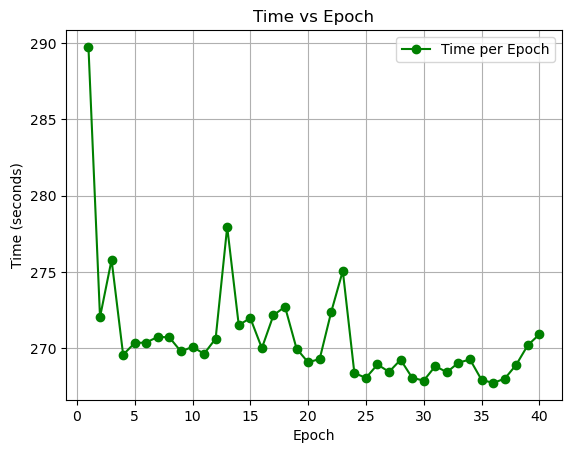

In [34]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, 41)  # since you have 40 epochs

# Plotting Time vs Epoch
plt.plot(epochs, time_callback.epoch_times, marker='o', linestyle='-', color='g', label='Time per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time vs Epoch')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


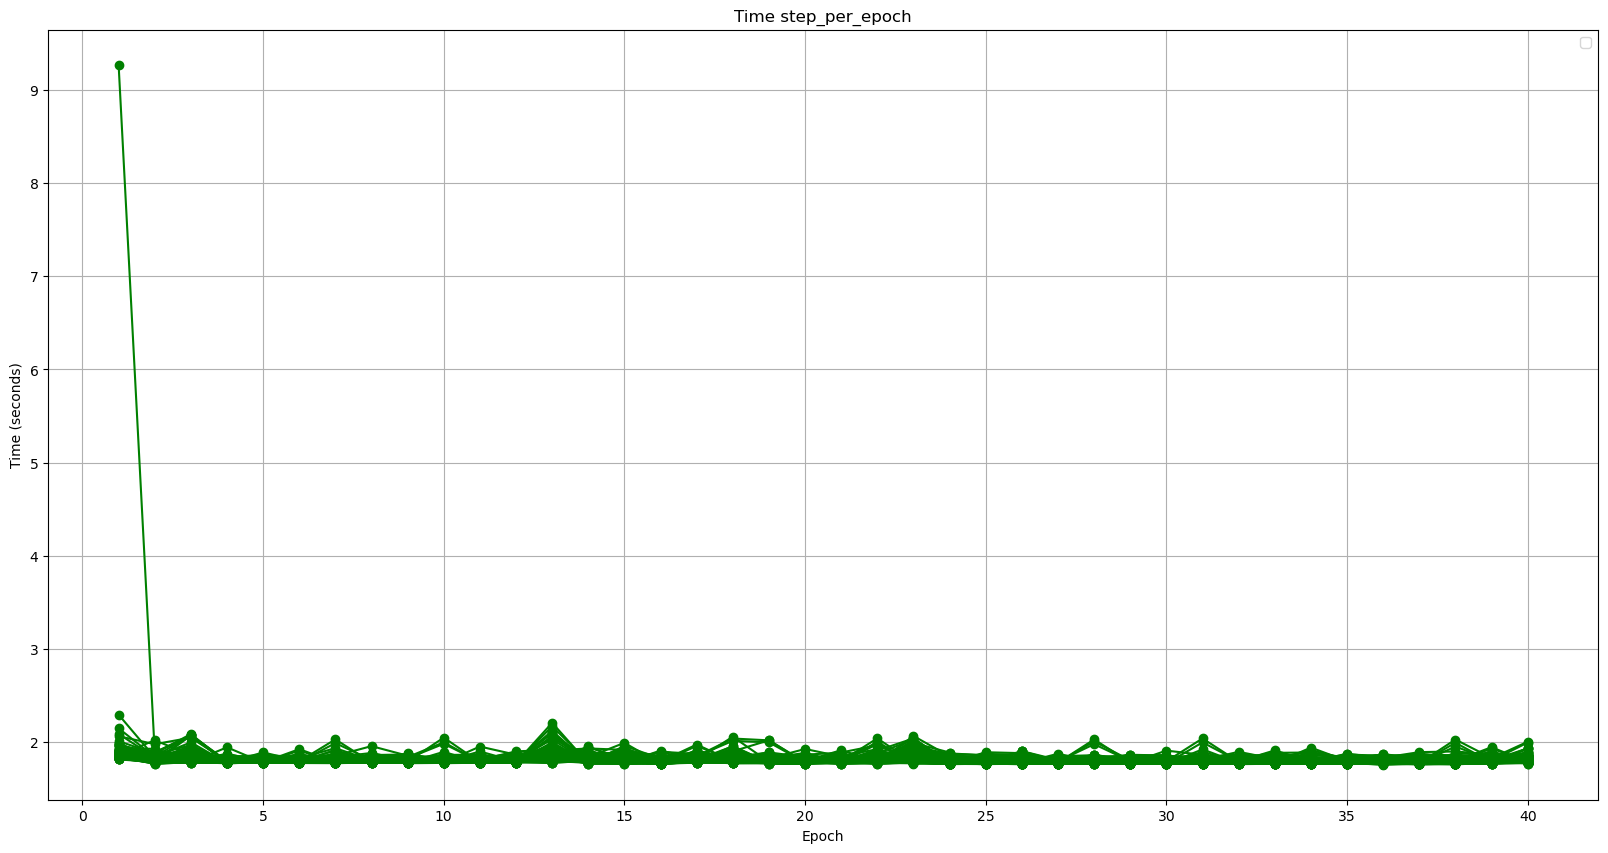

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10)) 
# Epochs
epochs = range(1, 41)  # since you have 20 epochs

# Plotting Time vs Epoch
plt.plot(epochs, time_callback.step_times, marker='o', linestyle='-', color='g')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Time step_per_epoch')
# plt.legend(loc='upper right')
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


AttributeError: 'History' object has no attribute 'loss'

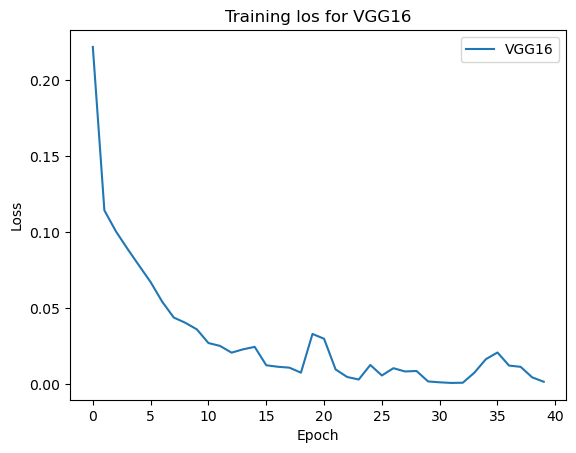

In [44]:
import matplotlib.pyplot as plt

# Plot training  loss values
plt.plot(history.history['loss'], label='VGG16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.yscale("log") 
plt.title('Training los for VGG16')
plt.legend()
plt.show()

In [37]:
validation = vgg16Model.evaluate(x_test,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 575ms/step - accuracy: 0.9943 - loss: 0.0262


In [38]:
validation

[0.016265247017145157, 0.9963333606719971]

In [39]:
history.history['val_loss']

[0.13443297147750854,
 0.12138582020998001,
 0.08805274218320847,
 0.07976420968770981,
 0.07118295133113861,
 0.06696057319641113,
 0.04882720112800598,
 0.05279024690389633,
 0.039535846561193466,
 0.040803212672472,
 0.027650069445371628,
 0.0460512600839138,
 0.05266455188393593,
 0.0261257104575634,
 0.026730217039585114,
 0.019487740471959114,
 0.02100188657641411,
 0.028318386524915695,
 0.05234913527965546,
 0.03228708729147911,
 0.03236960247159004,
 0.016819976270198822,
 0.04461648687720299,
 0.019948944449424744,
 0.0332866869866848,
 0.018773430958390236,
 0.03822431340813637,
 0.029960548505187035,
 0.017909584566950798,
 0.01616925559937954,
 0.014169147238135338,
 0.017596807330846786,
 0.017818152904510498,
 0.04586026445031166,
 0.04405273497104645,
 0.08484970033168793,
 0.027733420953154564,
 0.033868856728076935,
 0.01890994980931282,
 0.016265248879790306]

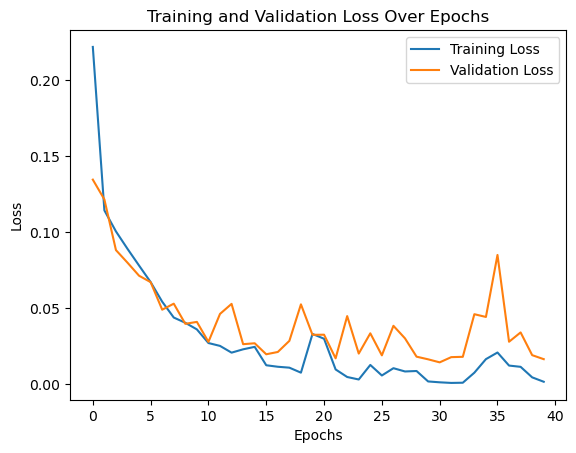

In [40]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


In [41]:
# prediction = vgg16Model.predict(x_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 578ms/step


In [107]:
# prediction


array([[1.55357971e-18, 1.00000000e+00, 6.42727793e-28],
       [1.00000000e+00, 2.25447547e-12, 2.13055296e-16],
       [1.03911684e-13, 1.00000000e+00, 1.38237602e-21],
       ...,
       [1.00000000e+00, 1.87232018e-11, 8.25291658e-12],
       [1.00000000e+00, 3.08290177e-12, 1.04223084e-14],
       [1.00000000e+00, 3.78339151e-13, 2.13610637e-13]], dtype=float32)

In [108]:
# prediction = np.argmax(prediction)

In [109]:
# prediction

1

In [116]:
# prediction = np.argmax(vgg16Model.predict(x_test),axis = -1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step


In [55]:
pred = np.argmax(vgg16Model.predict(x_test),axis = -1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 578ms/step


In [64]:
with open("pred.pkl", "wb") as file:  # "wb" means write binary
    pickle.dump(vgg16Model, file)

In [56]:
pred

array([0, 1, 2, ..., 2, 0, 0], dtype=int64)

In [57]:
pred[:10]

array([0, 1, 2, 2, 0, 1, 1, 1, 0, 0], dtype=int64)

In [58]:
y_test[:10]


array([0., 1., 2., 2., 0., 1., 1., 1., 0., 0.], dtype=float32)

In [59]:
y_test[:10].astype(int) #converted in int


array([0, 1, 2, 2, 0, 1, 1, 1, 0, 0])

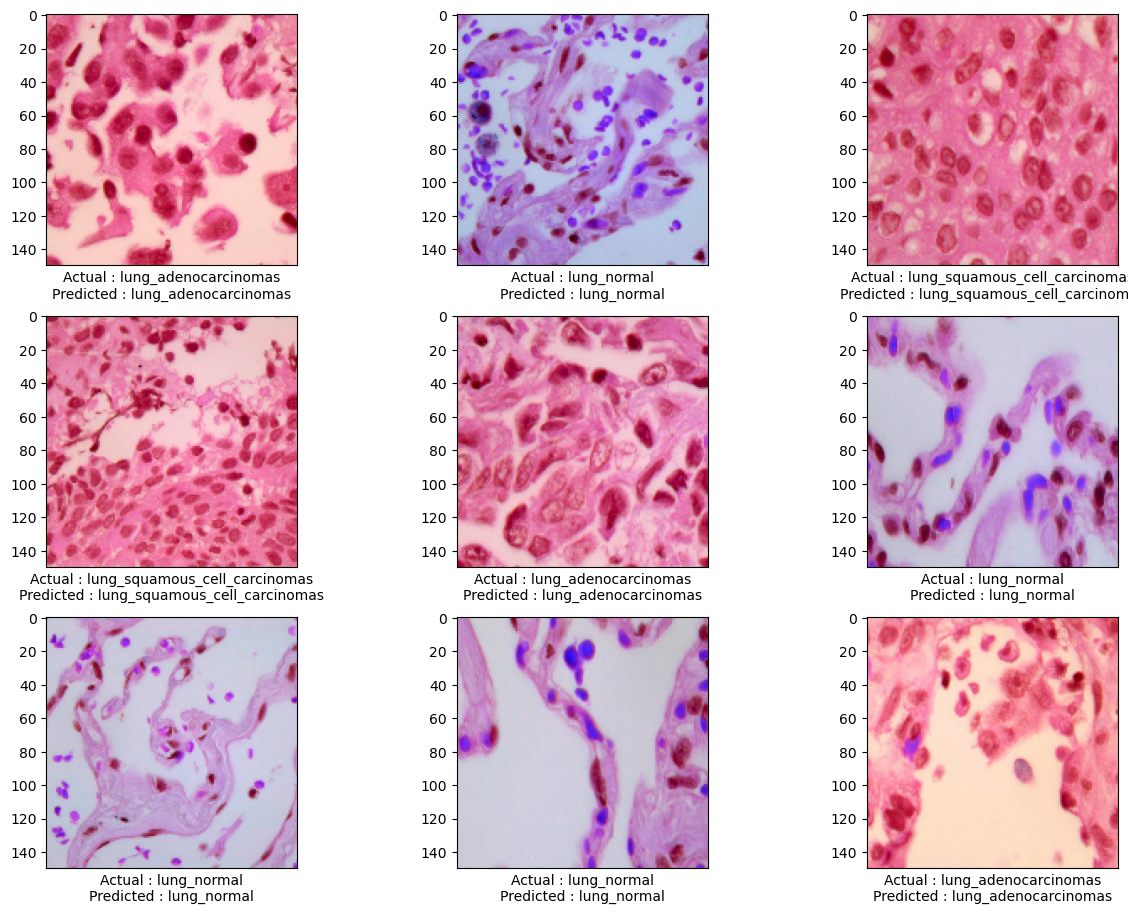

In [81]:
#Prediction Plot

plt.figure(figsize=(15,15))

for i in range(9):
    plt.subplot(4,3,i+1)
    plt.xlabel('Actual : '+Categories[int(y_test[i])] + '\n'+'Predicted : '+Categories[np.argmax(prediction[i])])
    plt.imshow(x_test[i])
    

    plt.xticks([])

plt.show()

In [69]:
from sklearn.metrics import confusion_matrix , classification_report
# np.argmax(element)
y_pred_classes = [element for element in pred]
print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1035
         1.0       1.00      1.00      1.00       966
         2.0       0.99      1.00      1.00       999

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [73]:
#Generate a Excel File
import pandas as pd

report_dict = classification_report(y_test, y_pred_classes, output_dict=True)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Save the DataFrame to an Excel file
report_df.to_excel("classification_report.xlsx", index=True)

In [70]:
# prediction

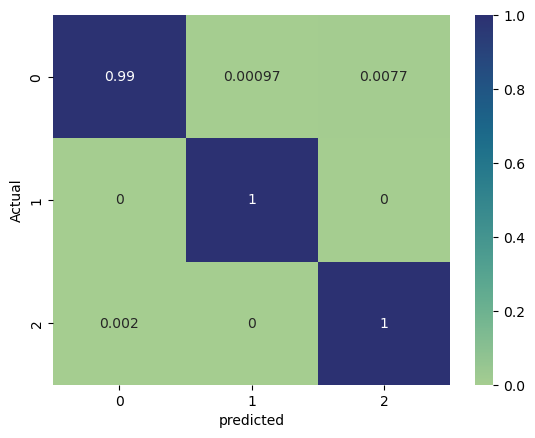

In [62]:
cf = confusion_matrix(y_test, pred, normalize='true')
import seaborn as sns
sns.heatmap(cf , annot = True , cmap = 'crest')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.show()

In [63]:
with open("cf.pkl", "wb") as file:  # "wb" means write binary
    pickle.dump(vgg16Model, file)